In [2]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.visualization import simple_norm
from astropy import units as u

from sherpa.astro.io import read_arf, read_rmf
from sherpa.astro import ui

from astropy.visualization import quantity_support

quantity_support()

 Solar Abundance Vector set to angr:  Anders E. & Grevesse N. Geochimica et Cosmochimica Acta 53, 197 (1989)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x16a49e590>

In [3]:
# Function to plot RGS plots
def plotRGS(plt, fileName, rgsfile, srcfile, source):
    hdu = fits.open(fileName)
    hdr = hdu[1].header
    ev = Table(hdu[1].data)

    plt.subplot(2, 1, 1)

    img = plt.hist2d(
        ev["M_LAMBDA"], ev["PI"], [360, 250], cmap="Oranges", vmin=0, vmax=5
    )
    hdu.close()

    hdu = fits.open(srcfile)
    inst = hdr["INSTRUME"].strip()
    reg = Table(hdu[inst + "_SRC" + str(source) + "_ORDER_1"].data)
    nreg = len(reg)

    for i in range(nreg):
        rr = reg[i]
        ii = np.nonzero(rr["LAMBDA"])
        if rr["SHAPE"][0] == "!":
            linest = ":r"
        else:
            linest = "-b"
        plt.plot(rr["LAMBDA"][ii], rr["PI"][ii], linest)

    plt.title(os.path.basename(fileName))
    plt.xlabel("Wavelength (A)")
    plt.ylabel("PI (eV)")

    hdu.close()

    plt.subplot(2, 1, 2)

    hdus = fits.open(rgsfile)
    r1 = Table(hdus[1].data)
    xdsp = np.degrees(r1["XDSP_CORR"]) * 3600.0
    plt.rcParams["figure.figsize"] = (12, 6)
    img, xe, ye = np.histogram2d(xdsp, r1["M_LAMBDA"], [250, 250])

    kernel = np.array(
        [[1, 1, 1], [1.0, 3.0, 1.0], [1.0, 9, 1.0], [1.0, 3.0, 1.0], [1.0, 1, 1.0]]
    )
    kernel = kernel / np.sum(kernel)
    imgs = convolve(img, kernel)

    plt.imshow(
        imgs,
        origin="lower",
        vmin=0,
        vmax=1.5,
        cmap="rainbow",
        extent=[ye[0], ye[-1], xe[0], xe[-1]],
        aspect="auto",
    )

    hdus.close()

    hdul = fits.open(srcfile)
    src = Table(hdul["SRCLIST"].data)
    dd = src["DELTA_XDSP"] * (-60)
    reg = Table(hdul["RGS1_SRC" + str(source) + "_SPATIAL"].data)
    nreg = len(reg)

    for i in range(nreg):
        rr = reg[i]
        ii = np.nonzero(rr["LAMBDA"])
        plt.plot(rr["LAMBDA"][ii], np.degrees(rr["XDSP_CORR"][ii]) * 3600, "r")
    reg = Table(hdul["RGS1_BACKGROUND"].data)
    nreg = len(reg)

    for i in range(nreg):
        rr = reg[i]
        ii = np.nonzero(rr["LAMBDA"])
        if rr["SHAPE"][0] != "!":
            linest = "-g"
        else:
            linest = "--y"
        plt.plot(
            rr["LAMBDA"][ii],
            np.degrees(rr["XDSP_CORR"][ii]) * 3600,
            linest,
            clip_on=True,
        )

    plt.xlabel("Wavelength")
    plt.ylabel("Cross-dispersion (arcsec)")
    plt.xlim([6.0, 32.0])

    hdul.close()

In [4]:
def get_file_names(dir, inst="R1"):
    """
    Assuming that there is only one exposure and thus exactly one file with this pattern
    """
    evt_list = glob.glob(os.path.join(dir, f"*{inst}*EVENLI0000.FIT"))
    src_list = glob.glob(os.path.join(dir, f"*{inst}*SRCLI_0000.FIT"))
    mer_list = glob.glob(os.path.join(dir, f"*{inst}*merged0000.FIT"))
    return evt_list[0], src_list[0], mer_list[0]

In [5]:
datadir = '../data'

In [6]:
evt_list, src_list, mer_list = get_file_names(datadir, "R1")

In [7]:
evt_list, src_list, mer_list

('../data/P0502370201R1S001EVENLI0000.FIT',
 '../data/P0502370201R1S001SRCLI_0000.FIT',
 '../data/P0502370201R1S001merged0000.FIT')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


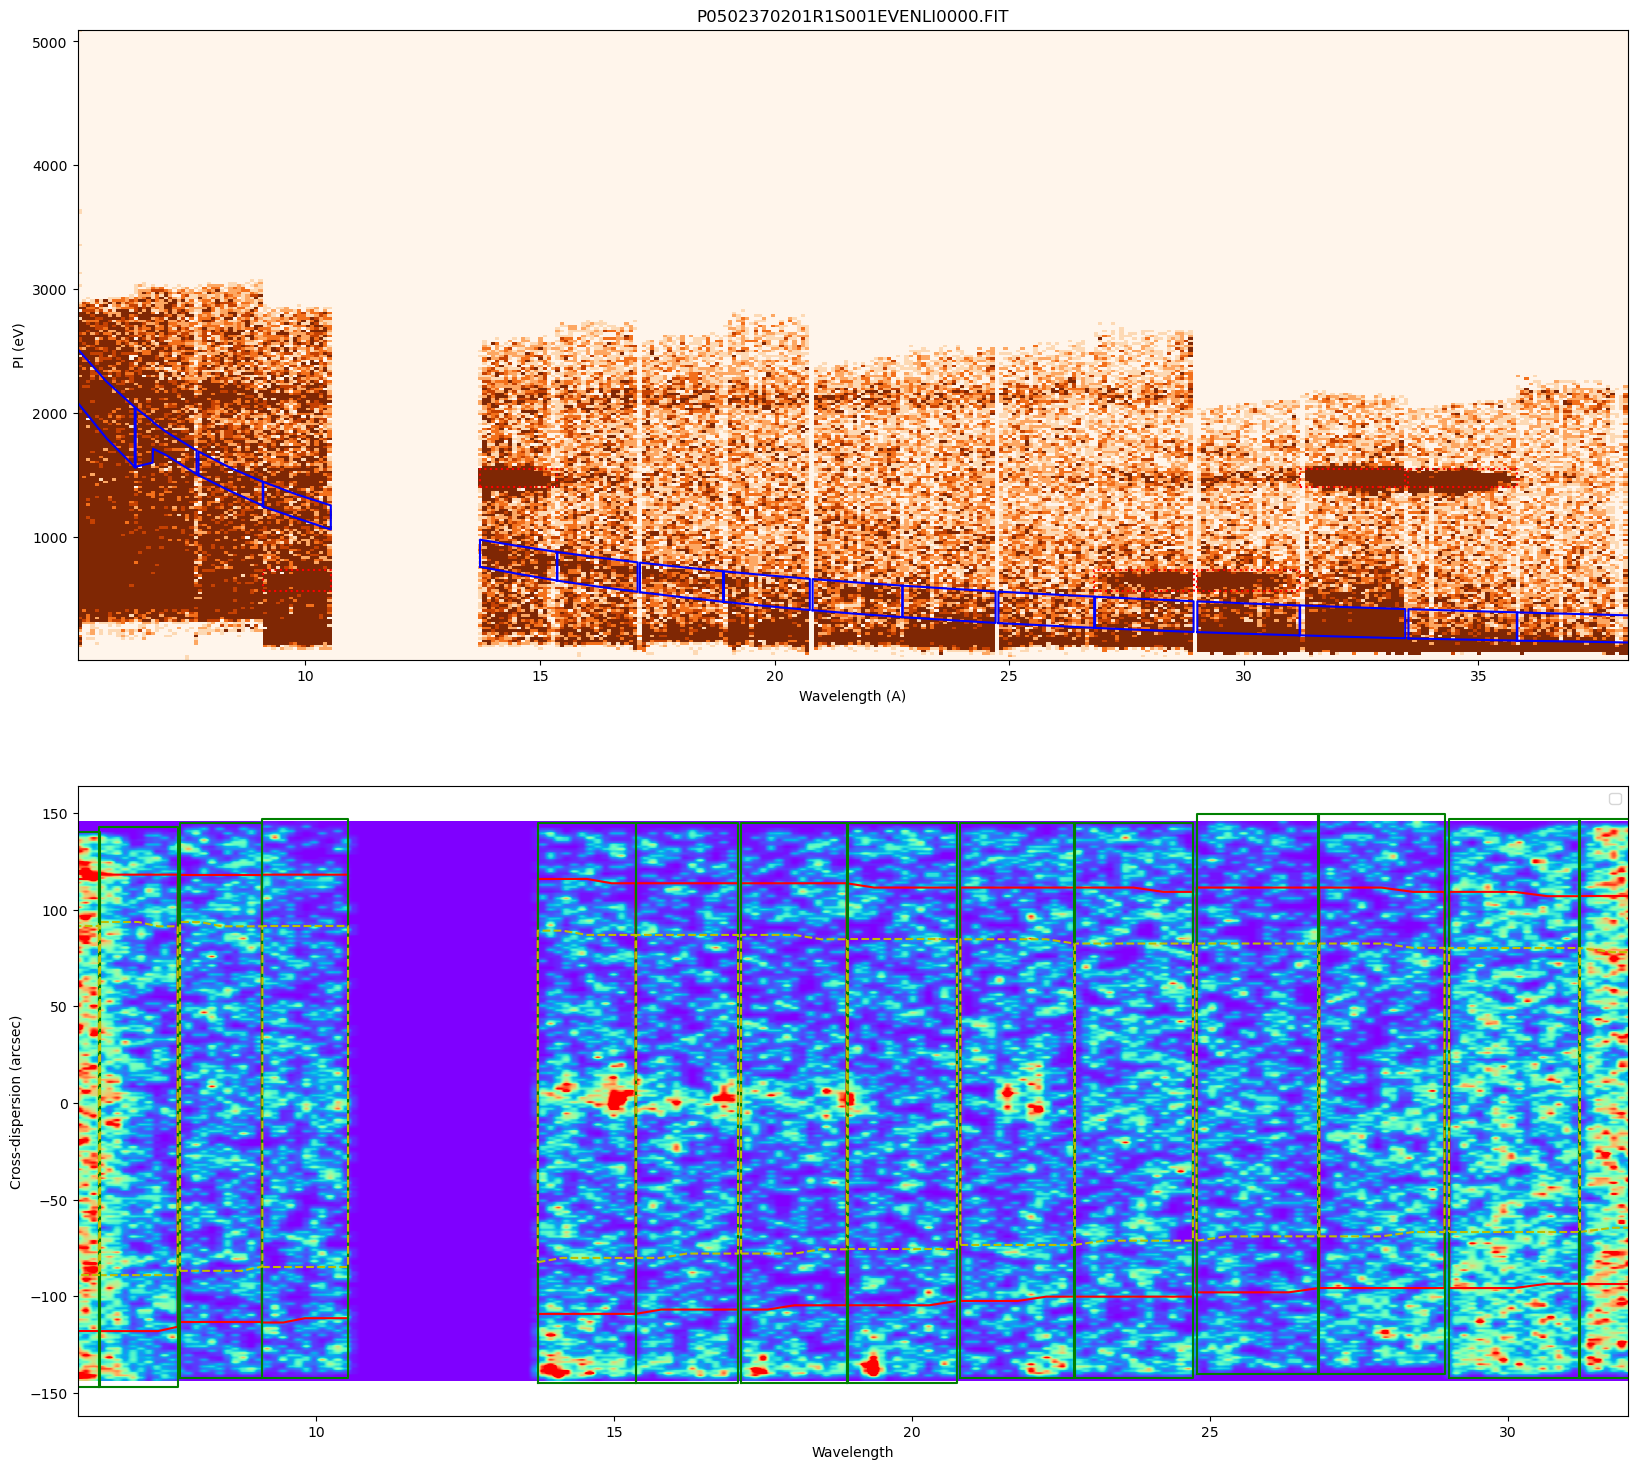

In [8]:
# Inspect plots

plt.figure(figsize=(20, 18))  # Size of figure

source = 1  # if user has defined the coordinate (1: default ; 3: user defined)
plotRGS(plt, evt_list, '../data/RGS1.fits', src_list, source)  # Plot RGS plots

plt.legend()

In [9]:
rgsfile = "../data/RGS1.fits"
src_list = "../data/psf_66/P0502370201R1S001SRCLI_0000.FIT"

In [10]:
hdulist = fits.open(evt_list)

In [11]:
ev = Table.read(evt_list, hdu=1)
ev_after_osip = Table.read(rgsfile, hdu=1)

inst = ev.meta["INSTRUME"]

src = Table.read(src_list, hdu="SRCLIST")
reg_energy = Table.read(src_list, hdu=f"{inst}_SRC{source}_ORDER_1")
reg_spatial = Table.read(src_list, hdu=f"{inst}_SRC{source}_SPATIAL")
reg_spatial["XDSP_CORR"].unit = u.rad
reg_spatial_bkg = Table.read(src_list, hdu=f"{inst}_BACKGROUND")
reg_spatial_bkg["XDSP_CORR"].unit = u.rad

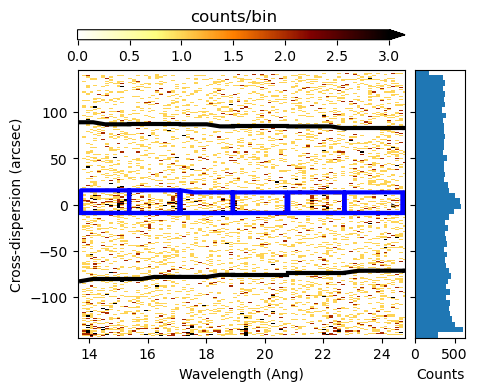

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

img, xe, ye = np.histogram2d(
    ev_after_osip["XDSP_CORR"].to(u.arcsec), ev_after_osip["M_LAMBDA"], [250, 250]
)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(
    img,
    origin="lower",
    vmin=0,
    vmax=3,
    cmap="afmhot_r",
    extent=[ye[0], ye[-1], xe[0], xe[-1]],
    aspect="auto",
    interpolation="nearest",
)

ii = np.nonzero(reg_spatial["LAMBDA"])
ax.plot(
    reg_spatial["LAMBDA"][ii],
    (reg_spatial["XDSP_CORR"][ii]).to(u.arcsec),
    color="b",
    lw=3,
)


for reg in reg_spatial_bkg:
    if reg["SHAPE"][0] != "!":
        continue
    for ii in (slice(0, 5), slice(5, 10)):
        ax.plot(
            reg["LAMBDA"][ii],
            (reg["XDSP_CORR"][ii] * reg_spatial_bkg["XDSP_CORR"].unit).to(u.arcsec),
            color="k",
            lw=3,
        )

ax.set_xlim(13.6, 24.8)
ax.set_xlabel("Wavelength (Ang)")
ax.set_ylabel("Cross-dispersion (arcsec)")

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histy = divider.append_axes("right", 0.5, pad=0.1, sharey=ax)
# make some labels invisible
ax_histy.yaxis.set_tick_params(labelleft=False)

ind = np.where((ev_after_osip["M_LAMBDA"] > 13.6) & (ev_after_osip["M_LAMBDA"] < 24.8))
y = ev_after_osip["XDSP_CORR"].to(u.arcsec)
out = ax_histy.hist(y, bins=50, orientation="horizontal")
ax_histy.set_xlabel("Counts")

ax_cbar = divider.append_axes("top", 0.1, pad=0.3)
plt.colorbar(im, cax=ax_cbar, orientation="horizontal", extend="max")
ax_cbar.set_title("counts/bin")

fig.savefig("../ADAP_proposal/rgs1_xdisp.pdf", dpi=300, bbox_inches="tight")

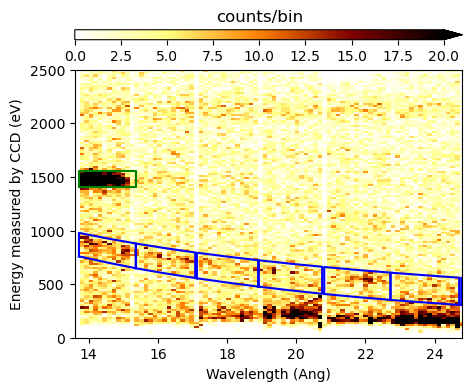

In [24]:
img, xe, ye = np.histogram2d(
    ev["PI"], ev["M_LAMBDA"], [250, 250]
)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(
    img,
    origin="lower",
    vmin=0,
    vmax=20,
    cmap="afmhot_r",
    extent=[ye[0], ye[-1], xe[0], xe[-1]],
    aspect="auto",
    interpolation="nearest",
)

for rr in reg_energy:
        ii = np.nonzero(rr["LAMBDA"])
        if rr["SHAPE"][0] == "!":
            linest = "-g"
        else:
            linest = "-b"
        ax.plot(rr["LAMBDA"][ii], rr["PI"][ii], linest)

ax.set_xlim(13.6, 24.8)
ax.set_ylim(0, 2500)
ax.set_xlabel("Wavelength (Ang)")
ax.set_ylabel("Energy measured by CCD (eV)")

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)


ax_cbar = divider.append_axes("top", 0.1, pad=0.3)
plt.colorbar(im, cax=ax_cbar, orientation="horizontal", extend='max')
ax_cbar.set_title("counts/bin")

fig.savefig("../ADAP_proposal/rgs1_pi.pdf", dpi=300, bbox_inches="tight")

In [15]:
bkg_rate = Table.read("../data/RGS1_FlareBKGRate.fit")

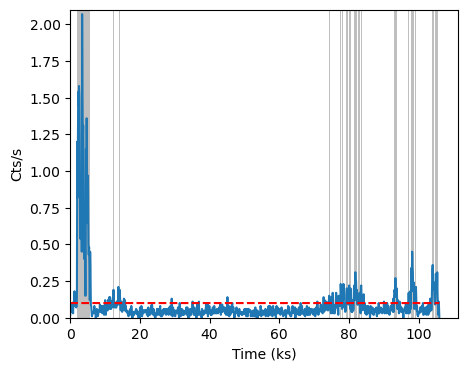

In [16]:
# Function to plot Lightcurve
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
times = (bkg_rate["TIME"] - bkg_rate["TIME"][0]) / 1e3
ax.plot(times, bkg_rate["RATE"])
ax.set_xlabel("Time (ks)")
ax.set_ylabel("Cts/s")

ax.plot(times, 0.1 * np.ones_like(times), "r--")
ax.fill_between(times, 2.5, where=bkg_rate["RATE"] > 0.1, facecolor="gray", alpha=0.5)
ax.set_ylim(0, 2.1)
ax.set_xlim(0, None)

fig.savefig("../ADAP_proposal/rgs1_bkg.pdf", dpi=300, bbox_inches="tight")

## RMF and fitting

In [17]:
rmf = read_rmf("../data/default/P0502370201R1S001RSPMAT1001.FIT")

In [18]:
type(rmf)

sherpa.astro.data.DataRMF

In [19]:
rmf.offset

1

In [20]:
rmf.n_grp.shape

(4000,)

In [21]:
        self.energ_lo = energ_lo
        self.energ_hi = energ_hi
        self.offset = offset
        self.detchans = detchans
        self.e_min = e_min
        self.e_max = e_max
        self.header = {} if header is None else header
        self.n_grp = n_grp
        self.f_chan = f_chan
        self.n_chan = n_chan
        self.matrix = matrix

NameError: name 'energ_lo' is not defined

In [ ]:
	Ngrp, a 2-byte INTEGER scalar for each row containing the number of 'channel subsets' for the energy bin (see below).
The FITS column name is N_GRP (unitless).
Fchan, a fixed- or variable-length 2-byte or 4-byte INTEGER array for each row. Contains the channel number of the start of each "channel subset" for the energy bin.
The FITS column name is F_CHAN (unitless).
Nchan, a fixed- or variable-length 2-byte or 4-byte INTEGER vector for each row. Contains the number of channels within each "channel subset" for the energy bin.
The FITS column name is N_CHAN (unitless).
Mat, a (fixed- or variable-length) REAL array. Each element Mat is 4-byte REAL number containing all the response probability values for each 'channel subset' corresponding to the energy bin for a given row.
The FITS column name is MATRIX (unitless). 

In [ ]:
# Sherpa stores f_chan, n_chan, etc. flattened only the non-zero values

# ignoring rmf.offset for now because it's only 1. 

# find max channel
max_channel = 0

ind = 0
for i, n_grp in enumerate(rmf.n_grp):
    for n in range(n_grp):
        max_channel = max(max_channel, rmf.f_chan[ind] + rmf.n_chan[ind])
        ind = ind + 1

mat = np.zeros(shape=(len(rmf.n_grp), max_channel))
ind = 0
ind_mat = 0
# Step though all rows
for i, n_grp in enumerate(rmf.n_grp):
    # and through every group in each row
    # to build up the matrix
    for n in range(n_grp):
        mat[i, rmf.f_chan[ind] : rmf.f_chan[ind] + rmf.n_chan[ind]] = rmf.matrix[
            ind_mat : ind_mat + rmf.n_chan[ind]
        ]
        ind_mat = ind_mat + rmf.n_chan[ind]
        ind = ind + 1

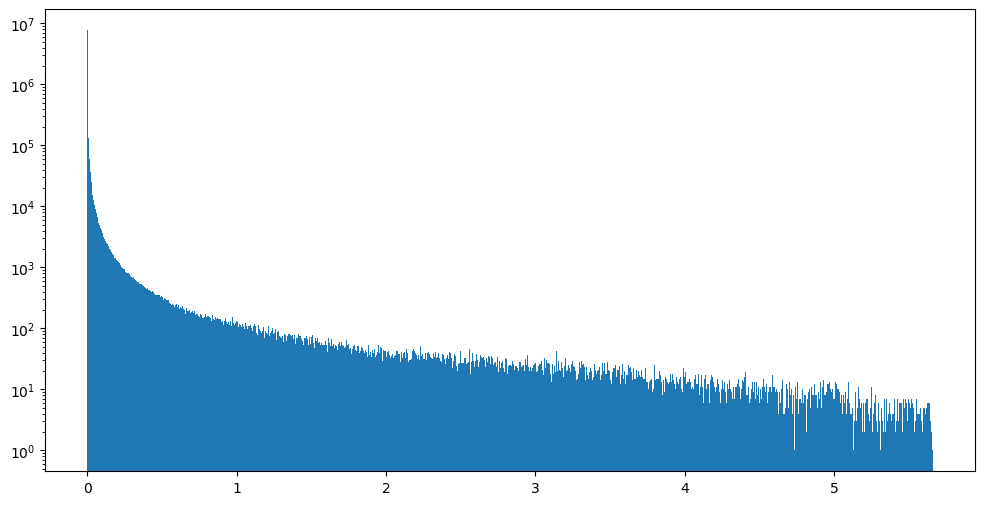

In [ ]:
# Just see distribution of non-zero values to help choose scaling for next plot
matflat = mat.flatten()
plt.hist(matflat[matflat > 0], bins=1000)
plt.yscale("log")

In [ ]:
mat.shape

NameError: name 'mat' is not defined

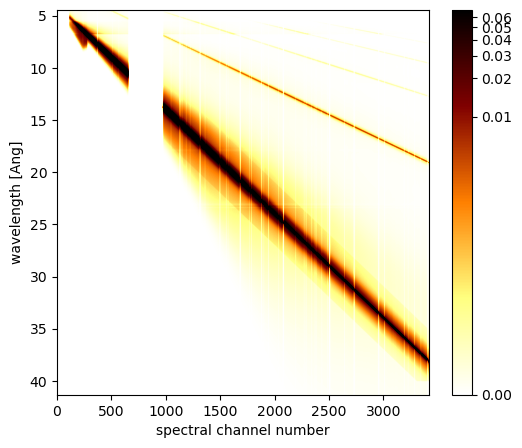

In [ ]:
norm = simple_norm(mat, "log", max_percent=99)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(
    mat,
    origin="lower",
    cmap="afmhot_r",
    norm=norm,
    extent=(
        0,
        max_channel,
        (rmf.energ_lo[0] * u.keV).to(u.Angstrom, equivalencies=u.spectral()).value,
        (rmf.energ_hi[-1] * u.keV).to(u.Angstrom, equivalencies=u.spectral()).value,
    ),
    aspect="auto",
)
ax.set_ylabel("wavelength [Ang]")
ax.set_xlabel("spectral channel number")
cbar = fig.colorbar(im)

In [ ]:
rmf.ethresh

1e-10

In [ ]:
rmf.f_chan[-100:].mean()

1405.4

In [ ]:
ui.load_pha("R1", "../data/default/P0502370201R1S001SRSPEC1001.FIT")
ui.load_rmf("R1", "../data/default/P0502370201R1S001RSPMAT1001.FIT")
ui.set_analysis('wave')

dataset R1: 4.01:39.99 Wavelength (Angstrom)


In [ ]:
ui.ignore(25, None)
ui.ignore(None, 7.5)

dataset R1: 6:25 Wavelength (Angstrom) (unchanged)
dataset R1: 6:25 -> 7.5:25 Wavelength (Angstrom)


In [ ]:
ui.set_source("R1", ui.xsphabs.abs1 * (ui.xsvapec.v1 + ui.xsvapec.v2))

In [ ]:
v1.kT = 0.5
abs1.nH = 0.1
v2.kT=4

In [ ]:
ui.set_stat('Cash')
ui.fit("R1")

Dataset               = R1
Method                = levmar
Statistic             = cash
Initial fit statistic = -72.1707
Final fit statistic   = -4013.9 at function evaluation 523
Data points           = 454
Degrees of freedom    = 449
Change in statistic   = 3941.73
   abs1.nH        6.23892e-05  +/- 0.00823282  
   v1.kT          0.25075      +/- 0           
   v1.norm        6.76684e-05  +/- 9.08393e-06 
   v2.kT          7.91558      +/- 0.419218    
   v2.norm        0.00213831   +/- 8.16327e-05 


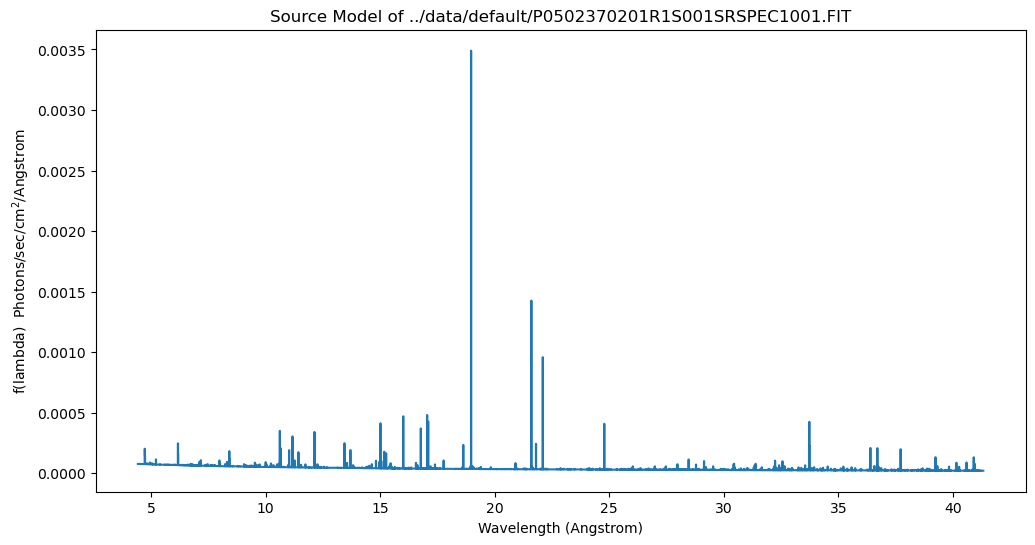

In [ ]:
ui.plot_source("R1")

dataset R1: 7.5:25 Wavelength (Angstrom) (unchanged)


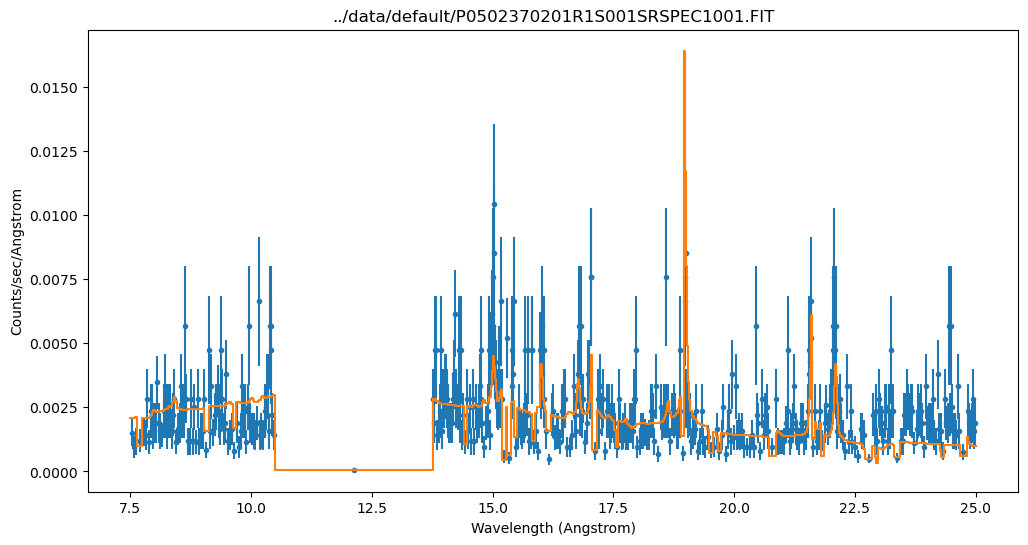

In [ ]:
ui.group_counts("R1", 5)
ui.plot_fit("R1")